<h2>Generating climbing route names with RNN</h2>

This project is a variation on the following tutorial: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) 

I generate rock climbing route names character by character. Training data was found on [kaggle](https://www.kaggle.com/dcohen21/8anu-climbing-logbook).

In [161]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import os
import time

In [266]:
df = pd.read_csv('climb_generator/ascent.csv', low_memory=False)

In [12]:
engl_countries = ['USA', 'GBR']

In [31]:
df_engl = df[df['country'].isin(engl_countries)].copy()

In [32]:
df_engl = df_engl.groupby('name').agg({'name':len})

In [34]:
df_engl.columns = ['count']

In [36]:
df_engl.reset_index(inplace=True)

12770


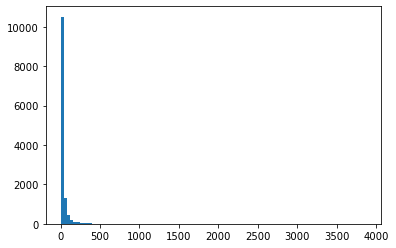

In [49]:
subset_df = df_engl[df_engl['count']>9].copy()
print(len(subset_df.index))
plt.hist(subset_df['count'],bins=100)
plt.show()

In [50]:
route_names = subset_df['name']

In [114]:
route_names = [x.replace("'",'') for x in route_names if len(str(x).split())>1]

In [115]:
len(route_names)

9762

In [116]:
len_list = [len(x) for x in route_names]
max_len = max(len_list)

In [117]:
route_names = [x+(' '*(max_len-len(x))) for x in route_names]

In [263]:
route_names[:5]

['#2 Arete                                          ',
 'v7 above longshot                                 ',
 '1/2 Route                                         ',
 '100 Proof Roof                                    ',
 '100 Years of Solitude                             ']

In [119]:
vocab = sorted(set(' '.join(route_names)))

In [120]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(),invert=True)

def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids),axis=-1)


In [121]:
all_ids = ids_from_chars(tf.strings.unicode_split(route_names,'UTF-8'))

In [122]:
BATCH_SIZE = 50
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [123]:
def split_input_target(seq):
    return seq[:-1], seq[1:]

In [124]:
dataset = ids_dataset.map(split_input_target)

In [128]:
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [130]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [132]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [133]:
model = MyModel(vocab_size=len(ids_from_chars.get_vocabulary()),
                  embedding_dim = embedding_dim,
                  rnn_units = rnn_units)

In [135]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

In [157]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 30
last_model_cpt = checkpoint_dir+f"/ckpt_{EPOCHS}.data-00000-of-00001"
if os.path.exists(last_model_cpt):
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
else:
    history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


./training_checkpoints/ckpt_30


In [158]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [159]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [261]:
start = time.time()
states = None
next_char = tf.constant(['S'])
result = [next_char]

res = route_names[0]
while res in route_names:
    for n in range(49):
        next_char, states = one_step_model.generate_one_step(next_char, states=states)
        result.append(next_char)

    result = tf.strings.join(result)

    res = result[0].numpy().decode('utf-8')
    
    result = [next_char]
    print(res)



Soul One                                          


In [262]:
res in route_names

False